# Joint Distributions
---

`tensorflow-probability` contains a `JointDistribution` class that can be used for multilevel and hierarchical bayesian modeling. Generally, We'll be using two classes:

* `JointDistributionSequential`: this distribution is similar to `tf.keras.Sequential` class, since in allows to build a model with a sequence of elements. In this case distributions or callables.
* `JointDistributionNamed`: this distribution builds a model from a dictionary of distributions or callables.

In [1]:
from local.lib.samplers import LinearRegressionSampler
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
tfd = tfp.distributions

2023-02-15 14:03:10.736758: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 14:03:10.826330: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-15 14:03:10.826348: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-15 14:03:11.400898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## OLS with Joint Distributions

In this example we'll use `JointDistribution` to build an Ordinary Least Squares (OLS) regression model, with the following structure:

$$
w_0 \sim \mathcal{N}(0, 1)\\
w_1 \sim \mathcal{N}(0, 1)\\
y \sim \mathcal{N}(w_1 * x + w_0, 1)
$$

First, let us load the data.

In [2]:
sampler = LinearRegressionSampler(noise_std=1.0)
data = sampler(1000, seed=42)

Let us visualize the data:

<Axes: xlabel='x_0', ylabel='y'>

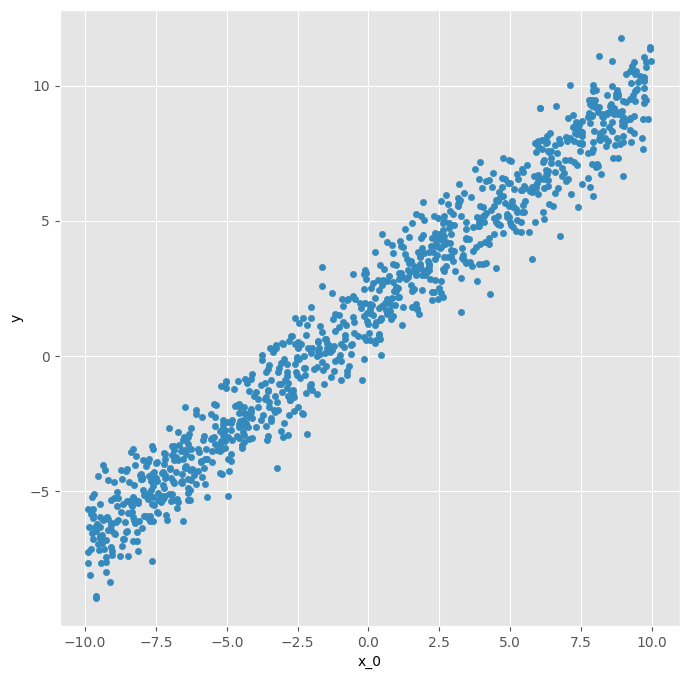

In [3]:
## KEEPOUTPUT
fig, ax = plt.subplots(figsize=(8, 8))
data.plot(x="x_0", y="y", kind="scatter", ax=ax)

The `JointDistributionNamed` class allows building a model using a syntax similar to it's mathematical definition.

In [4]:
def ols_model(x):
    model = tfd.JointDistributionNamedAutoBatched({
        "w_0": tfd.Normal(loc=tf.zeros(1), scale=1),
        "w_1": tfd.Normal(loc=tf.zeros(1), scale=1),
        "y": lambda w_1, w_0: tfd.Normal(
            loc=w_1 * x + w_0,
            scale=0.1
            )
        })
    return model

In this case, `AutoBatched` is used to automatically batch the data, i.e., we didn't consider the batch axis in the function that computes `y`. Also, the `JointDistributionNamed` class allows to define a multilevel model from a dictionary.

We can verify that the model is a linear regression model:

In [5]:
model = ols_model(data.x_0)

2023-02-15 14:03:14.037388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 14:03:14.037772: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-15 14:03:14.037884: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-15 14:03:14.037988: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-15 14:03:14.038098: W tensorflow/c

In [6]:
sample = model.sample(1)
y_prior = sample["y"]
w_0 = sample["w_0"][0, 0]
w_1 = sample["w_1"][0, 0]

Text(0.5, 1.0, '$y = -0.288 x + 2.034$')

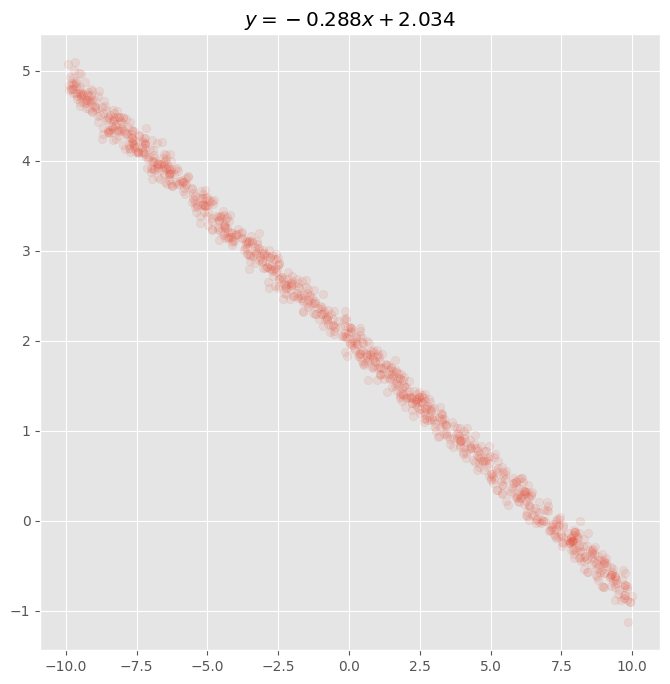

In [7]:
## KEEPOUTPUT
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(data.x_0, y_prior, label="data", alpha=0.1)
ax.set_title(f"$y = {w_1:.3f} x + {w_0:.3f}$")

We can solve the linear regression model using Markov Chain Monte Carlo:

In [8]:
def log_prob(w_0, w_1):
    return model.log_prob(w_0=w_0, w_1=w_1, y=data.y.values)

In [9]:
num_results = int(10e3)
burning_steps = int(1e3)

mcmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_prob,
    num_leapfrog_steps=3,
    step_size=1.,
    )
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
        mcmc_kernel, num_adaptation_steps=int(burning_steps * 0.8),
        )

In [10]:
samples, is_accepted = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=burning_steps,
    current_state=[tf.ones(1), tf.ones(1)],
    kernel=adaptive_hmc,
    trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )

Let's visualize the posterior distributions for the weights:

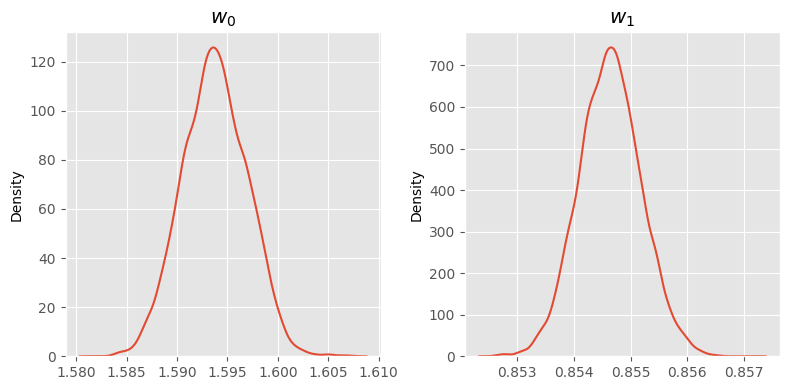

In [11]:
## KEEPOUTPUT
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(samples[0].numpy().flatten(), ax=ax[0])
sns.kdeplot(samples[1].numpy().flatten(), ax=ax[1])
ax[0].set_title("$w_0$")
ax[1].set_title("$w_1$")
fig.tight_layout()

Now, let's visualize the mean posterior model over the data:

In [12]:
## KEEPOUTPUT
w_0_mean = tf.reduce_mean(samples[0]).numpy()
w_1_mean = tf.reduce_mean(samples[1]).numpy()

print(f"mean(w_0): {w_0_mean:.3f}")
print(f"mean(w_1): {w_1_mean:.3f}")

mean(w_0): 1.594
mean(w_1): 0.855


In [13]:
x = np.linspace(data.x_0.min(), data.x_0.max(), 100)
y_pred = w_1_mean * x + w_0_mean

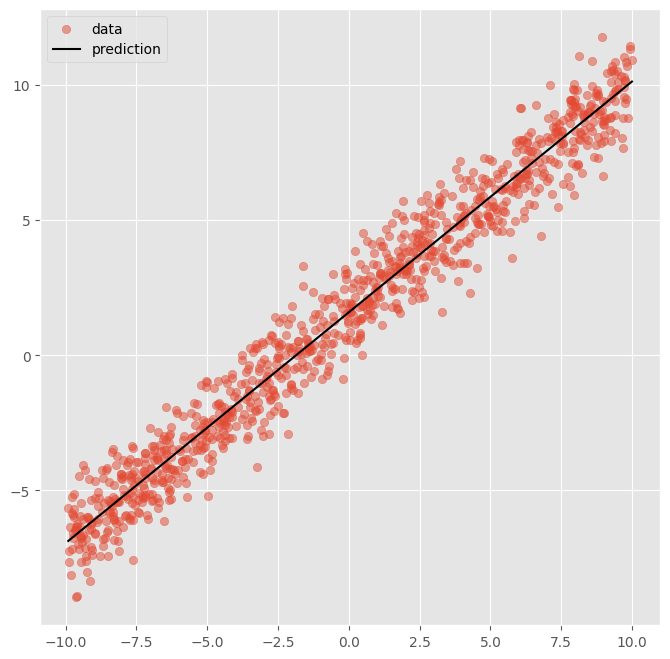

In [14]:
## KEEPOUTPUT
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(data.x_0, data.y, label="data", alpha=0.5)
ax.plot(x, y_pred, label="prediction", color="k")
ax.legend()